# Analyze RoME model output distribution

In [101]:
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import math
import scipy

from dsets import KnownsDataset
from experiments.causal_trace import *

## Define functions for analyzing model distributions

In [2]:
def get_top_k_tokens(distrib, k, mt):
    top_vals, top_ix = torch.topk(distrib, k)
    return {mt.tokenizer.decode(top_ix[ix]): float(top_vals[ix]) for ix in range(len(top_vals))}    

## Analysis example

In [129]:
model_name = "gpt2-xl"
data_dir = "/cephyr/users/lovhag/Alvis/projects/rome/data/P103_gpt2_xl_preds.jsonl"
samples = 10
noise_level_arg = "s3"

mt = ModelAndTokenizer(model_name, torch_dtype=None)

knowns = []
with open(data_dir) as f:
    for line in f:
        loaded_example = json.loads(line)
        knowns.append(loaded_example)

In [132]:
data = pd.DataFrame(knowns)
data.subject.unique()

array(['Louis Jules Trochu', 'Valeria Bruni Tedeschi', 'Pierre Messmer',
       'Roger Nimier', 'Andrey Malakhov', 'Emmanuelle Arsan',
       'Georges Mouton', 'Nie Weiping', 'Laurent Lafitte',
       'Joseph Reinach', 'Russians', 'Claude Aveline', 'Jan Commelin',
       'Jean Rotrou', 'Laura Smet', 'Sara Coleridge',
       'Jean-Antoine Chaptal', 'Raymond Queneau', 'Fernand David',
       'Guy Sorman', 'Jean-Luc Marion', 'Goncourt brothers',
       'Victor de Riqueti, marquis de Mirabeau', 'Gustaaf Schlegel',
       'Dmitry Rybolovlev', 'Sophie Marceau', 'Louis-Nicolas Davout',
       'Paul-Jean Toulet', 'Adrien Duport', 'Lionel Jospin',
       'Dmitry Malikov', 'Michel Bouquet', 'William Henry Harrison',
       'Jean Rouch', 'Alain Delon', 'Alfred Marie-Jeanne',
       'Philippe de Mornay', 'Michel de Montaigne', 'Yevgeny Yevtushenko',
       'Pierre Alcover', 'Pierre-Alexandre-Laurent Forfait',
       'Imanol Arias', 'Marthe Mellot', 'Daniel Ceccaldi',
       'Jean-Pierre Marielle',

In [133]:
data[data.subject=='Oleg Novitskiy']

,subject,attribute,template,prediction,prompt,relation_id,known_id,prediction_p,candidate_prediction,candidate_p,candidate_rank,gold_rank,gold_p
458,Oleg Novitskiy,Russian,The native language of {} is,Russian,The native language of Oleg Novitskiy is,P103,458,0.499103,Russian,0.499103,0,0,0.499103
459,Oleg Novitskiy,Russian,The mother tongue of {} is,Russian,The mother tongue of Oleg Novitskiy is,P103,459,0.520616,Russian,0.520616,0,0,0.520616


In [134]:
data[data.subject=='Colette Darfeuil']

,subject,attribute,template,prediction,prompt,relation_id,known_id,prediction_p,candidate_prediction,candidate_p,candidate_rank,gold_rank,gold_p
572,Colette Darfeuil,French,The native language of {} is,French,The native language of Colette Darfeuil is,P103,572,0.405984,French,0.405984,0,0,0.405984
573,Colette Darfeuil,French,The mother tongue of {} is,French,The mother tongue of Colette Darfeuil is,P103,573,0.431761,French,0.431761,0,0,0.431761


Get uncorrupted prob distrib

In [130]:
def get_probs(prompt, subject):
    # Get uncorrupted prob distrib
    inp = make_inputs(mt.tokenizer, [prompt] * (samples + 1))
    inp_one = make_inputs(mt.tokenizer, [prompt])
    with torch.no_grad():
        out = mt.model(**inp_one)["logits"]
        probs = torch.softmax(out[:, -1], dim=1)
        
    # Setup noise level and token ranges for corrupting subject tokens
    token_range = None
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    if token_range == "subject_last":
        token_range = [e_range[1] - 1]
    elif token_range is not None:
        raise ValueError(f"Unknown token_range: {token_range}")

    uniform_noise = False
    if isinstance(noise_level_arg, str):
        if noise_level_arg.startswith("s"):
            # Automatic spherical gaussian
            # factor = float(noise_level_arg[1:]) if len(noise_level_arg) > 1 else 1.0
            # noise_level = factor * collect_embedding_std(
            #     mt, [k["subject"] for k in knowns]
            # )
            # print(f"Using noise_level {noise_level} to match model times {factor}")
            # From previous logs: "Using noise_level 0.13667432963848114 to match model times 3.0" (for relation P19?)
            noise_level = 0.1367
        elif noise_level_arg == "m":
            # Automatic multivariate gaussian
            noise_level = collect_embedding_gaussian(mt)
            print(f"Using multivariate gaussian to match model noise")
        elif noise_level_arg.startswith("t"):
            # Automatic d-distribution with d degrees of freedom
            degrees = float(noise_level_arg[1:])
            noise_level = collect_embedding_tdist(mt, degrees)
        elif noise_level_arg.startswith("u"):
            uniform_noise = True
            noise_level = float(noise_level_arg[1:])
       
    # Get model probabilities under corrupted subject tokens
    answer_t = None
    low_score = trace_with_patch(
            mt.model, inp, [], answer_t, e_range, noise=noise_level, uniform_noise=uniform_noise
        )
    
    return probs[0], low_score

Pick a prompt

In [144]:
knowns_ix = 573
print(knowns[knowns_ix])
prompt = knowns[knowns_ix]["prompt"]
subject = knowns[knowns_ix]["subject"]

probs, low_score = get_probs(prompt, subject)

{'subject': 'Colette Darfeuil', 'attribute': 'French', 'template': 'The mother tongue of {} is', 'prediction': ' French', 'prompt': 'The mother tongue of Colette Darfeuil is', 'relation_id': 'P103', 'known_id': 573, 'prediction_p': 0.43176097, 'candidate_prediction': ' French', 'candidate_p': 0.43176097, 'candidate_rank': 0, 'gold_rank': 0, 'gold_p': 0.43176097}


### Plot

In [145]:
k = 10
perturbed_score = [] # low_score[:5]
data_list = [get_top_k_tokens(probs, k=k, mt=mt)] + [get_top_k_tokens(val, k=k, mt=mt) for val in perturbed_score]
data = pd.DataFrame(data_list,
                    index = ["original"] + [f"corrupted_{ix}" for ix in range(len(perturbed_score))])
cols = list(data.columns)
data = data.reset_index()
data = pd.melt(data, id_vars="index", value_vars=cols)

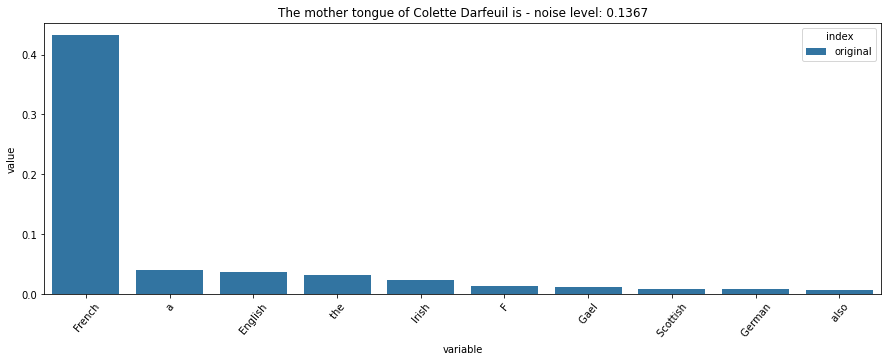

In [146]:
plt.figure(figsize=(15, 5))
sns.barplot(data, x="variable", y="value", hue="index")
plt.xticks(rotation=50)
plt.title(f"{prompt} - noise level: {noise_level}")
plt.show()

## P19 - Calculate KL divergence between distributions for top 10 tokens from orig prompt

In [125]:
data = pd.DataFrame(knowns)
data.head()

,subject,attribute,template,prediction,prompt,relation_id,known_id,prediction_p,candidate_prediction,candidate_p,candidate_rank,gold_rank,gold_p
0,Allan Peiper,Alexandra,{} was born in,New,Allan Peiper was born in,P19,0,0.038592,London,0.024580,2,3197,0.000011
1,Allan Peiper,Alexandra,{} is originally from,the,Allan Peiper is originally from,P19,1,0.077758,Canada,0.029013,2,3354,0.000011
2,Allan Peiper,Alexandra,{} was originally from,the,Allan Peiper was originally from,P19,2,0.079163,Canada,0.023173,2,3389,0.000013
3,Allan Peiper,Alexandra,{} is native to,the,Allan Peiper is native to,P19,3,0.154659,Canada,0.035623,2,4780,0.000005
4,Allan Peiper,Alexandra,{} was native to,the,Allan Peiper was native to,P19,4,0.132673,Canada,0.032304,1,4640,0.000007


In [95]:
orig_prompt_ix = 0
subject = "Claude Arrieu"
curr_data = data[data.subject==subject]
curr_data.head()

,subject,attribute,template,prediction,prompt,relation_id,known_id,prediction_p,candidate_prediction,candidate_p,candidate_rank,gold_rank,gold_p
28,Claude Arrieu,Paris,{} was born in,Paris,Claude Arrieu was born in,P19,28,0.195481,Paris,0.195481,0,0,0.195481
29,Claude Arrieu,Paris,{} is originally from,France,Claude Arrieu is originally from,P19,29,0.225198,France,0.225198,0,2,0.073581
30,Claude Arrieu,Paris,{} was originally from,France,Claude Arrieu was originally from,P19,30,0.163905,France,0.163905,0,2,0.059420
31,Claude Arrieu,Paris,{} is native to,France,Claude Arrieu is native to,P19,31,0.190283,France,0.190283,0,2,0.058785
32,Claude Arrieu,Paris,{} was native to,the,Claude Arrieu was native to,P19,32,0.197732,France,0.114440,1,2,0.041610


In [122]:
k = 10
lama_orig_probs, _ = get_probs(curr_data.iloc[0]["prompt"], curr_data.iloc[0]["subject"])
mask = lama_orig_probs<torch.topk(lama_orig_probs, k).values[-1]
lama_orig_probs[mask] = 0

kl_div = []
for _, sample in curr_data.iterrows():
    orig_probs, _ = get_probs(sample["prompt"], sample["subject"])
    kl_div.append(sum(scipy.special.rel_entr(lama_orig_probs.cpu(), orig_probs.cpu())))

In [123]:
kl_div

[tensor(0.),
 tensor(0.2382),
 tensor(0.2676),
 tensor(0.2838),
 tensor(0.3251),
 tensor(0.3269),
 tensor(0.2732)]

Compare against the KL divergence for some other subject (Allan Peiper)

In [126]:
subject = "Allan Peiper"
curr_data = data[data.subject==subject]
curr_data.head()

,subject,attribute,template,prediction,prompt,relation_id,known_id,prediction_p,candidate_prediction,candidate_p,candidate_rank,gold_rank,gold_p
0,Allan Peiper,Alexandra,{} was born in,New,Allan Peiper was born in,P19,0,0.038592,London,0.024580,2,3197,0.000011
1,Allan Peiper,Alexandra,{} is originally from,the,Allan Peiper is originally from,P19,1,0.077758,Canada,0.029013,2,3354,0.000011
2,Allan Peiper,Alexandra,{} was originally from,the,Allan Peiper was originally from,P19,2,0.079163,Canada,0.023173,2,3389,0.000013
3,Allan Peiper,Alexandra,{} is native to,the,Allan Peiper is native to,P19,3,0.154659,Canada,0.035623,2,4780,0.000005
4,Allan Peiper,Alexandra,{} was native to,the,Allan Peiper was native to,P19,4,0.132673,Canada,0.032304,1,4640,0.000007


In [128]:
kl_div = []
for _, sample in curr_data.iterrows():
    orig_probs, _ = get_probs(sample["prompt"], sample["subject"])
    kl_div.append(sum(scipy.special.rel_entr(lama_orig_probs.cpu(), orig_probs.cpu())))
    
kl_div

[tensor(1.0442),
 tensor(1.4035),
 tensor(1.3781),
 tensor(1.5533),
 tensor(1.4303),
 tensor(1.3935),
 tensor(1.3025)]